## Imports

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
from matplotlib import pyplot as plt
from keras.datasets import mnist
from tensorflow.python.keras.utils.layer_utils import count_params
from keras import utils, models, layers

## Helper functions

In [2]:
# FLOP computation from: https://github.com/tokusumi/keras-flops/issues/19#issuecomment-1840278299
def get_flops(model):
    forward_pass = tf.function(model.call, input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
    graph_info = profile(forward_pass.get_concrete_function().graph, options=ProfileOptionBuilder.float_operation())
    flops = graph_info.total_float_ops
    return flops

def get_params(model):
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    return trainable_count + non_trainable_count

## Load the dataset

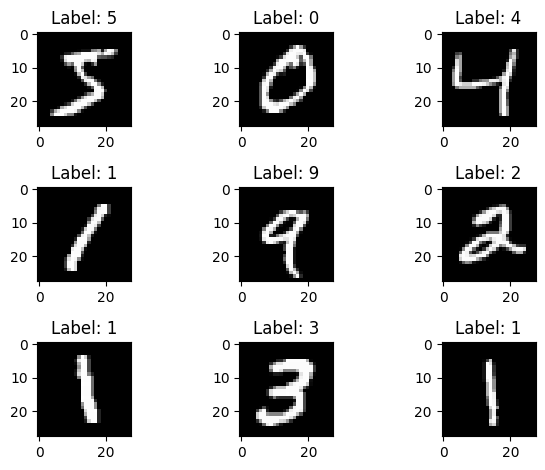

In [3]:
# Shape of the input images
image_shape = (28, 28, 1)

# Load the MNIST dataset
(train_x, train_y), (test_x, test_y) = mnist.load_data()
# Plot the first nine images with their respective labels
num_examples = 9
for i in range(num_examples):
    ax = plt.subplot(331 + i)
    ax.imshow(train_x[i], cmap=plt.get_cmap("gray"))
    ax.title.set_text(f"Label: {train_y[i]}")
plt.tight_layout()
plt.show()

## Incorrect labels

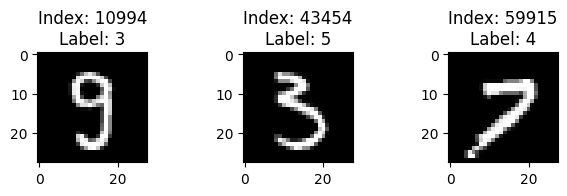

In [4]:
# Plot examples of incorrect labels
incorrect_label_indices = [10994, 43454, 59915]
for i in range(3):
    ax = plt.subplot(331 + i)
    index = incorrect_label_indices[i]
    ax.imshow(train_x[index], cmap=plt.get_cmap("gray"))
    ax.title.set_text(f"Index: {index}\nLabel: {train_y[index]}")
plt.tight_layout()
plt.show()

## Data preprocessing

In [5]:
# Ensure that the images are 28 x 28 pixels in size
train_x = train_x.reshape((train_x.shape[0], *image_shape))
test_x = test_x.reshape((test_x.shape[0], *image_shape))

# Rescale each entry from range [0-255] to range [0-1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# Convert the classes to binary matrices
train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

print(f"Image dimensions: {train_x.shape[1]}px by {train_x.shape[2]}px")
print(f"Training samples: {train_x.shape[0]}")
print(f"Testing samples:  {test_x.shape[0]}")

Image dimensions: 28px by 28px
Training samples: 60000
Testing samples:  10000


## Define and compile the baseline model

In [6]:
# Baseline model from Google Colab MNIST convnet example: https://github.com/keras-team/keras-io/blob/4d5893f38419eb1e7096d806a453dcde33b12c35/examples/vision/ipynb/mnist_convnet.ipynb
baseline = models.Sequential(
    [
        layers.Input(shape=image_shape),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(rate=0.5),
        layers.Dense(units=10, activation="softmax"),
    ]
)

baseline.summary()
baseline_flops = get_flops(baseline)
baseline_params = get_params(baseline)
baseline.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(f"Baseline FLOPs: {get_flops(baseline):,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

## Train and evaluate the baseline model

In [ ]:
# Train the model
baseline.fit(x=train_x, y=train_y, batch_size=128, epochs=15, validation_split=0.1)
# Print formatted results
baseline_results = baseline.evaluate(test_x, test_y)
print(f"Loss:     {baseline_results[0]:.3%}")
print(f"Accuracy: {baseline_results[1]:.3%}")

## Define the test models

In [7]:
test_models = []

conv_16 = models.Sequential(
    [
        layers.Input(shape=image_shape),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(rate=0.5),
        layers.Dense(units=10, activation="softmax"),
    ]
)
conv_16.summary()
test_models.append(conv_16)


conv_16_32_64 = models.Sequential(
    [
        layers.Input(shape=image_shape),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(rate=0.5),
        layers.Dense(units=10, activation="softmax"),
    ]
)
conv_16_32_64.summary()
test_models.append(conv_16_32_64)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        27,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,210 (106.29 KB)

 Trainable params: 27,210 (106.29 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,946 (93.54 KB)

 Trainable params: 23,946 (93.54 KB)

 Non-trainable params: 0 (0.00 B)

## Train and evaluate the test models

In [ ]:
accuracies = [baseline_results[1]]
params = [baseline_params]
flops = [baseline_flops]

for model in test_models:
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    flops.append(get_flops(model))
    params.append(get_params(model))
    model.fit(x=train_x, y=train_y, batch_size=128, epochs=15, validation_split=0.1)
    results = model.evaluate(test_x, test_y)
    accuracies.append(results[1])

accuracy_point_per_flop = []
for i in range(len(accuracies)):
    accuracy_point_per_flop.append(accuracies[i] / flops[i])

additional_accuracy_per_flop = []
for i in range(len(accuracies)):
    additional_accuracy_per_flop.append((accuracies[i] - accuracies[0]) / flops[i])

## Graphing the results

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches((16, 8))
model_names = ["Baseline", "Test Model A", "Test Model B"]

ax1.bar(model_names, height=[a-0.97 for a in accuracies], bottom=0.97)
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy for each model")

ax2.bar(model_names, params)
ax2.set_ylabel("Parameters")
ax2.set_title("Number of parameters for each model")

ax3.bar(model_names, flops)
ax3.set_ylabel("FLOPs")
ax3.set_title("Number of FLOPs for each model")

ax4.bar(model_names, accuracy_point_per_flop)
ax4.set_ylabel("Accuracy point per FLOP")
ax4.set_title("Accuracy point per FLOP for each model")

plt.tight_layout()
plt.show()